In [1]:
%load_ext autoreload
%autoreload 2


# Variational Autoencoders [2, 3, 1]

Autoencoders, which we discussed earlier, learn a compressed representation of input data, i.e. learn how to compress the data to latent space (encoder) and decompress it back (decoder). This makes them prone to overfitting and often useless when it comes to their generative abilities.

To overcome this issue, **Variational Autoencoders (VAEs)** were proposed as a generalization of a vanilla autoencoder to generative model. Instead of learning a function, that maps input to and from latent space, VAEs learn the parameters of an unknown  probability distribution representing the data $p_{\theta^*}\left(\mathbf{z}\right)$. 

![vae](assets/vae.png)

Let's focus on the generative model $p_\theta\left(\mathbf{z}\right)p_\theta\left(\mathbf{x}\vert\mathbf{z}\right)$, which is denoted by solid lines. We have a dataset $\mathbf{X} = \left\{\mathbf{x}^{\left(i\right)}\right\}_{i=1}^N$, which consists of $N$ iid samples of some variable $\mathbf{x}$. We assume that this data is generated by some random process, involving an unobserved continuous random variable $\mathbf{z}$. This process consists of the following steps:

* a latent vector $\mathbf{z}^{\left(i\right)}$ is generated from prior distribution $p_{\theta^*}\left(\mathbf{z}\right)$
* a value $\mathbf{x}^{\left(i\right)}$ is generated from some conditional distribution $p_{\theta^*}\left(\mathbf{x}\vert\mathbf{z}\right)$

with an assumption that the prior $p_{\theta^*}\left(\mathbf{z}\right)$ and likelihood $p_{\theta^*}\left(\mathbf{x}\vert\mathbf{z}\right)$ come from parametric families of distributions $p_{\theta}\left(\mathbf{z}\right)$ and $p_{\theta}\left(\mathbf{x}\vert\mathbf{z}\right)$ and that their PDFs are differentiable w.r.t. both $\theta$ and $\mathbf{z}$ almost everywhere. We allow each $\mathbf{x}^{\left(i\right)}$ to depend on $\mathbf{z}^{\left(i\right)}$ in a complex, non-linear way. In our case, this dependency will be parametrized by a neural network with parameters $\theta$.

To learn the parameters of the approximation of the true conditional we would need to maximize the likelihood of the training data:

$$p\left(x\right) = \int p_\theta\left(\mathbf{x}\vert\mathbf{z}\right)p\left(\mathbf{z}\right)dz$$

This would however require integrating over all the possible values of prior. To overcome this problem we introduce a probabilistic encoder model $q_\phi\left(\mathbf{z}\vert\mathbf{x}\right)$ (depicted as dashed lines on the image) - an approximation to the intractable true posterior $p_\theta\left(\mathbf{z}\vert\mathbf{x}\right)$, whose parameters are defined by a function (in our case - another parametrised neural network, with parameters $\phi$). In this case, the aforementioned generative model $p_{\theta^*}\left(\mathbf{x}\vert\mathbf{z}\right)$ becomes a kind of probabilistic decoder.

We can therefore formulate our training objective as follows:

$$\begin{align}
\log p_\theta\left(\mathbf{x}\right) & = \mathbb{E}_{\mathbf{z} \sim q_\phi\left(\mathbf{z}\vert\mathbf{x}\right)} \left[\log p_\theta\left(\mathbf{x}\right)\right] & \text{$p_\theta\left(\mathbf{x}\right)$ is independent of $\mathbf{z}$}\\
& = \mathbb{E}_{\mathbf{z}}\left[\log\frac{p_\theta\left(\mathbf{x}\vert\mathbf{z}\right)p\left(\mathbf{z}\right)}{p\left(\mathbf{z}\vert\mathbf{x}\right)}\right] & \text{Bayes' Rule}\\
& = \mathbb{E}_{\mathbf{z}}\left[\log\frac{p_\theta\left(\mathbf{x}\vert\mathbf{z}\right)p\left(\mathbf{z}\right)}{p\left(\mathbf{z}\vert\mathbf{x}\right)}\frac{q_\phi\left(\mathbf{z}\vert\mathbf{x}\right)}{q_\phi\left(\mathbf{z}\vert\mathbf{x}\right)}\right] & \text{Multiply by 1}\\
& = \mathbb{E}_{\mathbf{z}}\left[\log p_\theta\left(\mathbf{x}\vert\mathbf{z}\right)\right] - \mathbb{E}_{\mathbf{z}}\left[\log \frac{q_\phi\left(\mathbf{z}\vert\mathbf{x}\right)}{p\left(\mathbf{z}\right)}\right] + \mathbb{E}_{\mathbf{z}}\left[\log \frac{q_\phi\left(\mathbf{z}\vert\mathbf{x}\right)}{p\left(\mathbf{z}\vert\mathbf{x}\right)}\right] & \text{Logarithm}\\
& = \underbrace{\mathbb{E}_{\mathbf{z}}\left[\log p_\theta\left(\mathbf{x}\vert\mathbf{z}\right)\right] - D_{KL}\left(q_\phi\left(\mathbf{z}\vert\mathbf{x}\right)\| p\left(\mathbf{z}\right)\right)}_{\mathcal{L}\left(\mathbf{x}, \theta, \phi\right)} + \underbrace{D_{KL}\left(q_\phi\left(\mathbf{z}\vert\mathbf{x}\right)\| p\left(\mathbf{z}\vert\mathbf{x}\right)\right)}_{\ge 0}\\
\end{align}$$

The KL divergence of the approximation and true posterior distribution cannot be optimized directly. We know, that it is greater or equal to zero.

Therefore, we can transform this equation to the following inequality (ELBO):

$$\log p_\theta \left(\mathbf{x}\right) \ge \underbrace{\mathbb{E}_{\mathbf{z}}\left[\log p_\theta\left(\mathbf{x}\vert\mathbf{z}\right)\right]}_{\text{reconstruction term}} - \underbrace{D_{KL}\left(q_\phi\left(\mathbf{z}\vert\mathbf{x}\right)\| p\left(\mathbf{z}\right)\right)}_{\text{approximate posterior regularization}} = \mathcal{L}\left(\mathbf{x}, \theta, \phi\right)$$

The KL divergence is calculated by comparing parametrized $q_\phi\left(\mathbf{z}\vert\mathbf{x}\right)$ with a standard normal distribution $\mathcal{N}\left(0, I\right)$

MLE training objective: $\theta^*, \phi^* = \underset{\theta, \phi}{\arg\max} \sum_{i=1}^N \mathcal{L}\left(x_i, \theta, \phi\right)$

In other words, the goal of inference is to find values of $\theta$ and $\phi$, so that the log evidence $\log p_\theta \left(\mathbf{x}\right)$ is large (the model fits the data well) and the variational distribution $q_\phi\left(\mathbf{z}\vert\mathbf{x}\right)$ is a good approximation of the posterior.

> [[2] Knigma, D., Weeling, M. *Auto-Encoding Variational Bayes*. 2013.](https://arxiv.org/pdf/1312.6114.pdf)

> [[3] Rezende, D., Moamed, S., Wierstra, D., *Stochastic Backpropagation and Approximate Inference in Deep Generative Models*. 2014.](https://arxiv.org/pdf/1401.4082.pdf)

> [[1] Goodfellow, I., Bengio, Y., Courville, A. *Deep Learning*. 2016.](https://www.deeplearningbook.org/contents/generative_models.html)


## Implementing a VAE

In this task our aim is to train a VAE in a similar way to AE presented in the previous notebook. We will be using MNIST dataset, transformed to values in range $\left[0, 1\right]$.

Start with implementing the encoder `VEncoder` and decoder `VDecoder` networks (in `src/vae.py`) - we would like them to be neural networks with one hidden layer (its size set by a hyperparameter). Use appropriate non-linearities (see the previous lab), so that the latent distribution parameters are set appropriately (note limitations of mean and standard deviation), and the output reconstruction retains the characteristics of the input.

Then, proceed to implementing the variational autoencoder `VariationalAutoEncoder` (in `src/vae.py`): fill `model` and `guide` functions according to VAE definition and provide `encoder_forward` and `decoder_forward` functions, that will use the class attributes: `encoder` and `decoder` (see the docstrings for requirements; these functions are used for further analysis).


### Loading data


In [2]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

np.random.seed(0)


In [3]:
train_dataset = MNIST(
    root="data",
    download=True,
    train=True,
    transform=ToTensor()  # converts numpy form to torch tensor in range [0, 1]
)
test_dataset = MNIST(
    root="data",
    download=True,
    train=False,
    transform=ToTensor()
)

# limiting the dataset
indices = np.random.permutation(len(train_dataset.data))[:10_000]
train_dataset.data = train_dataset.data[indices]
train_dataset.targets = train_dataset.targets[indices]


In [4]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=False
)


### Preparing and training the model

We now instantiate the implemented model; both encoder and decoder networks have 128 hidden neurons, and we use latent space of 20 elements. We then proceed to training the model using `Trace_ELBO` and Adam optimizer.


In [5]:
# you have to fill the implementation in the source file
from src.vae import VariationalAutoEncoder


model = VariationalAutoEncoder(
    n_data_features=28 * 28,  # MNIST pixels
    n_encoder_hidden_features=128,  # chosen arbitrarily
    n_decoder_hidden_features=128,  # chosen arbitrarily
    n_latent_features=30  # how many features will be used to represent input
)


In [6]:
from src.utils import train_vae

from pyro.infer import Trace_ELBO


epochs = 20
LR = 1e-3

loss_fn = Trace_ELBO()

train_metrics, test_metrics = train_vae(
    model=model,
    epochs=epochs,
    train_loader=train_loader,
    test_loader=test_loader,
    lr=LR,
    loss_fn=loss_fn
)


Epoch: 1 / 20.



Epoch: 2 / 20.



Epoch: 3 / 20.



Epoch: 4 / 20.



Epoch: 5 / 20.



Epoch: 6 / 20.



Epoch: 7 / 20.



Epoch: 8 / 20.



Epoch: 9 / 20.



Epoch: 10 / 20.



Epoch: 11 / 20.



Epoch: 12 / 20.



Epoch: 13 / 20.



Epoch: 14 / 20.



Epoch: 15 / 20.



Epoch: 16 / 20.



Epoch: 17 / 20.



Epoch: 18 / 20.



Epoch: 19 / 20.



Epoch: 20 / 20.


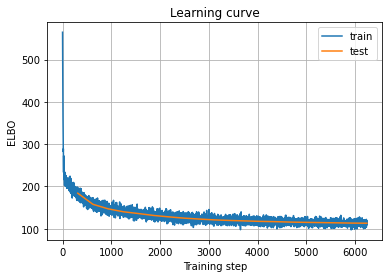

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(
    train_metrics["step"],
    train_metrics["loss"],
    label="train"
)
ax.plot(
    test_metrics["step"],
    test_metrics["loss"],
    label="test"
)
ax.set_xlabel("Training step")
ax.set_ylabel("ELBO")
ax.set_title("Learning curve")
ax.legend()
ax.grid()
plt.show()


### Reconstruction analysis

Here we can analyze the performance of the model when it comes to reconstructing the input. Apart from comparing reconstructions with the original input, we provide 5 samplings of the same input, to prove probabilistic nature of the model.


In [8]:
from src.utils import AutoEncoderAnalyzer
import matplotlib.pyplot as plt


In [9]:
analyzer = AutoEncoderAnalyzer(
    model=model,
    dataset=test_dataset,
    n_samplings=3
)


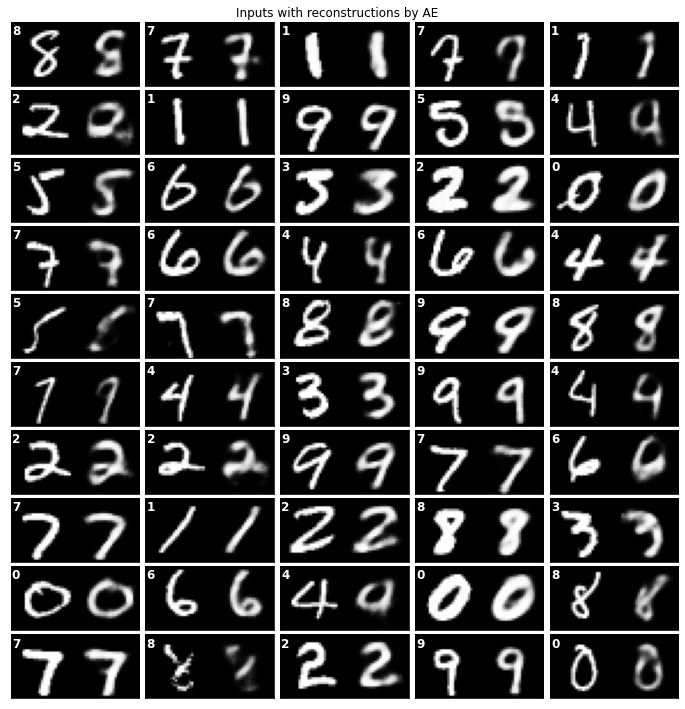

In [10]:
analyzer.compare_reconstruction_with_original()
plt.show()


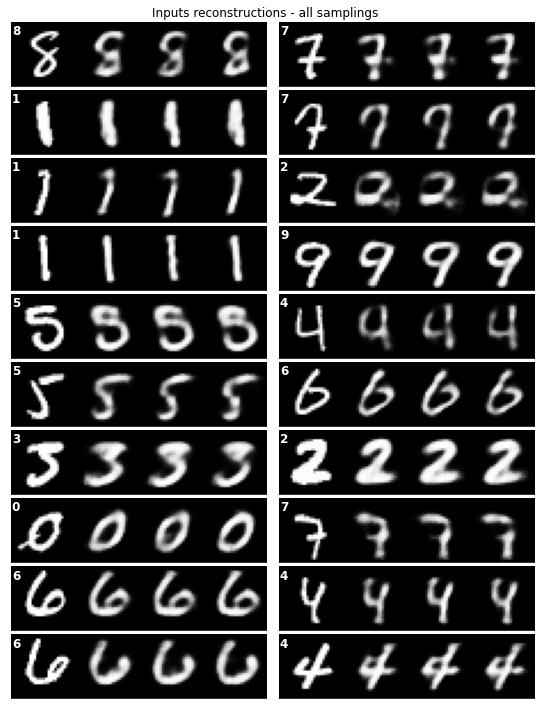

In [11]:
analyzer.compare_samplings()
plt.show()


### Generative capabilities

As in AE, we would like to view the average representation of each digit. We also perform an analysis of how varying each latent vector influences the output (the range of changes is calculated automatically).


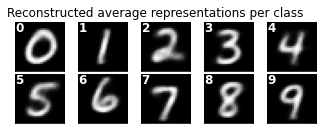

In [12]:
analyzer.average_points_per_class()
plt.show()


Digit: 0
Researching values in range [-6.0, 6.0]


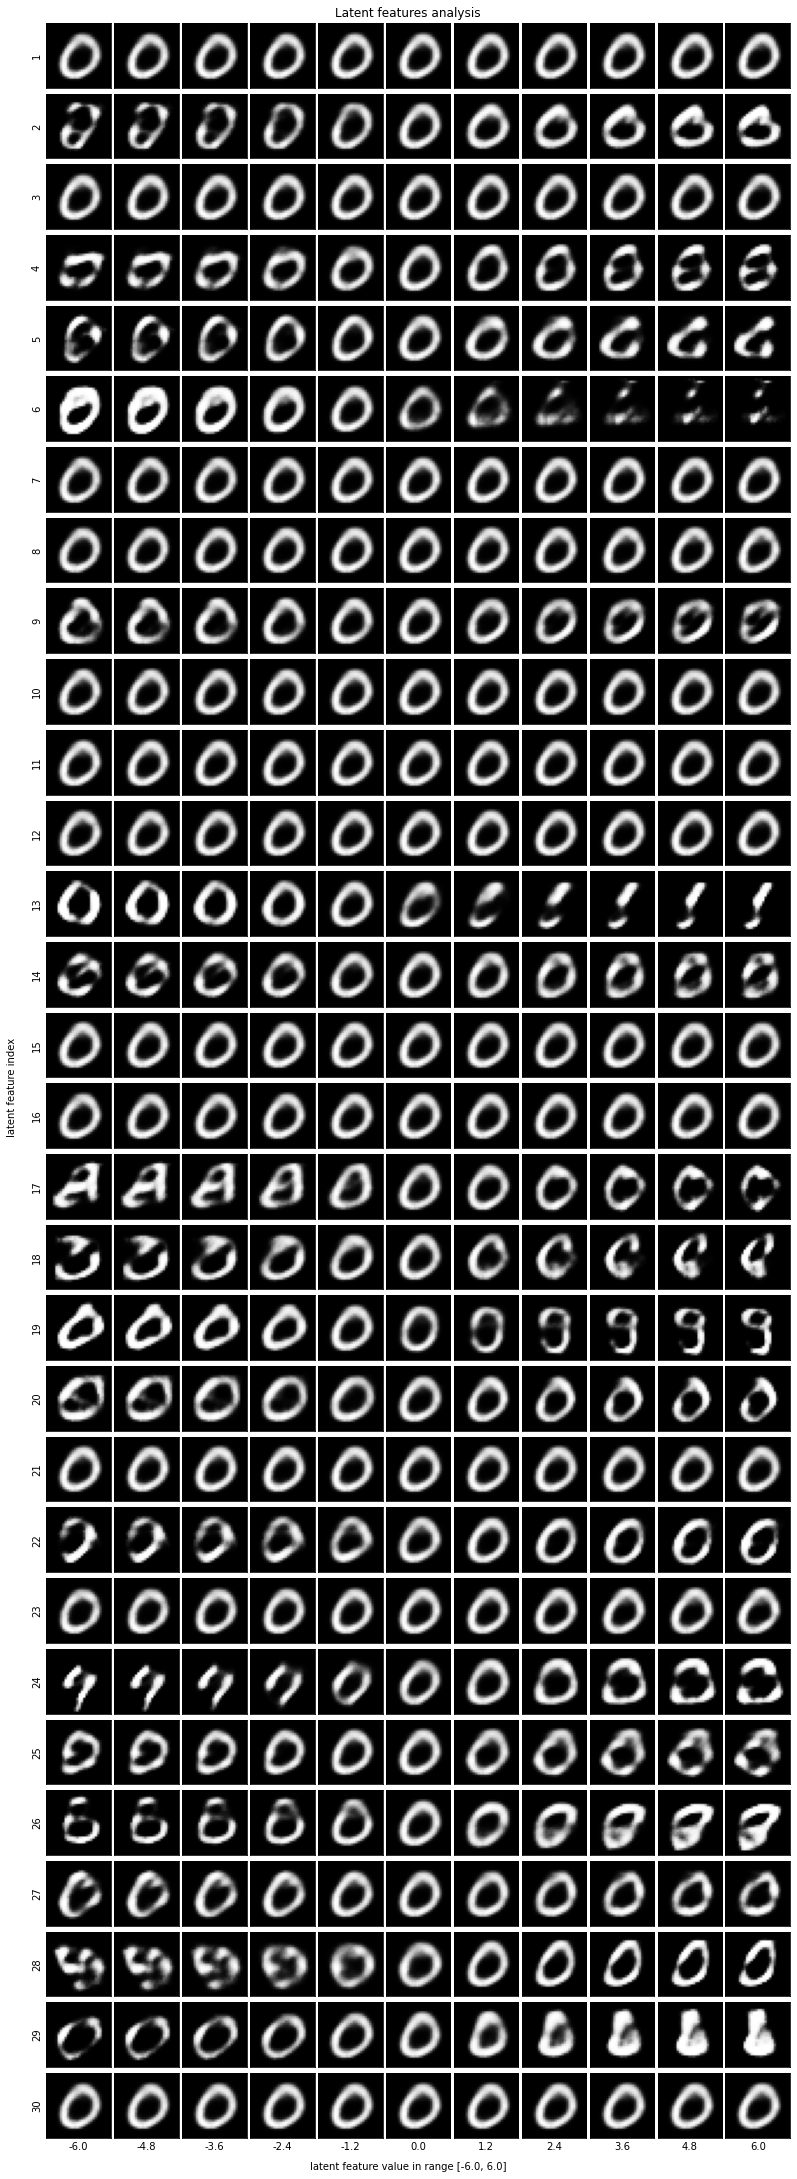

Digit: 1
Researching values in range [-6.0, 6.0]


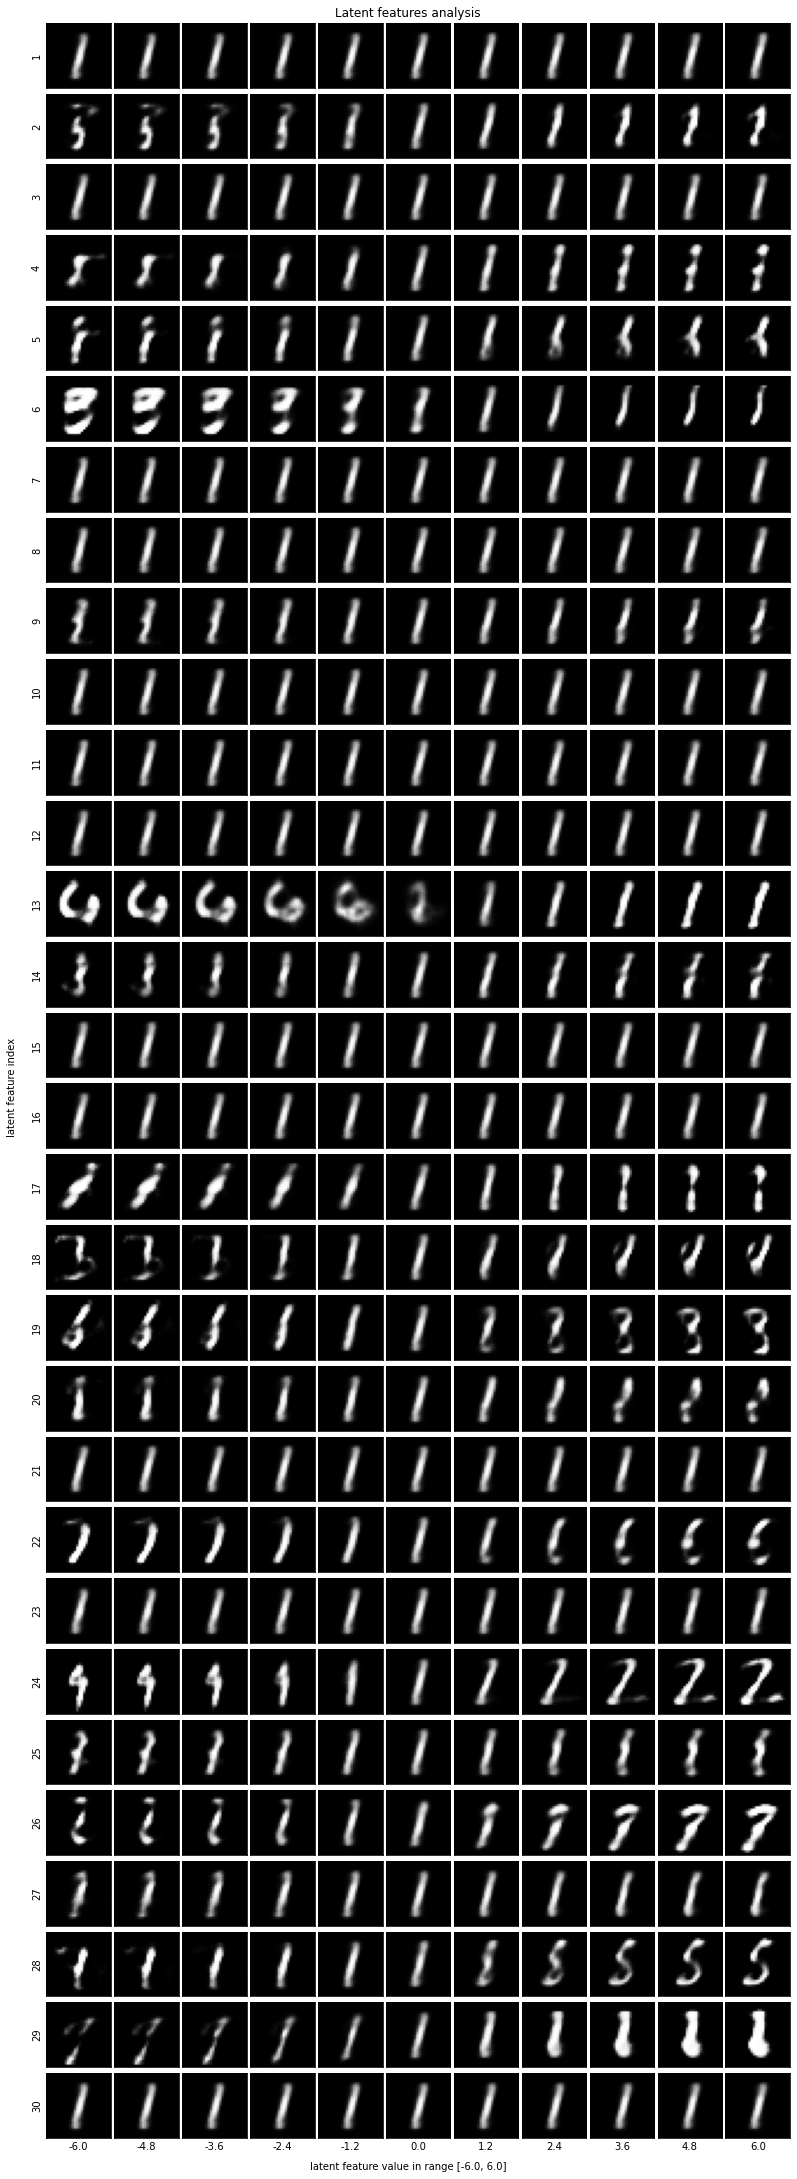

Digit: 2
Researching values in range [-6.0, 6.0]


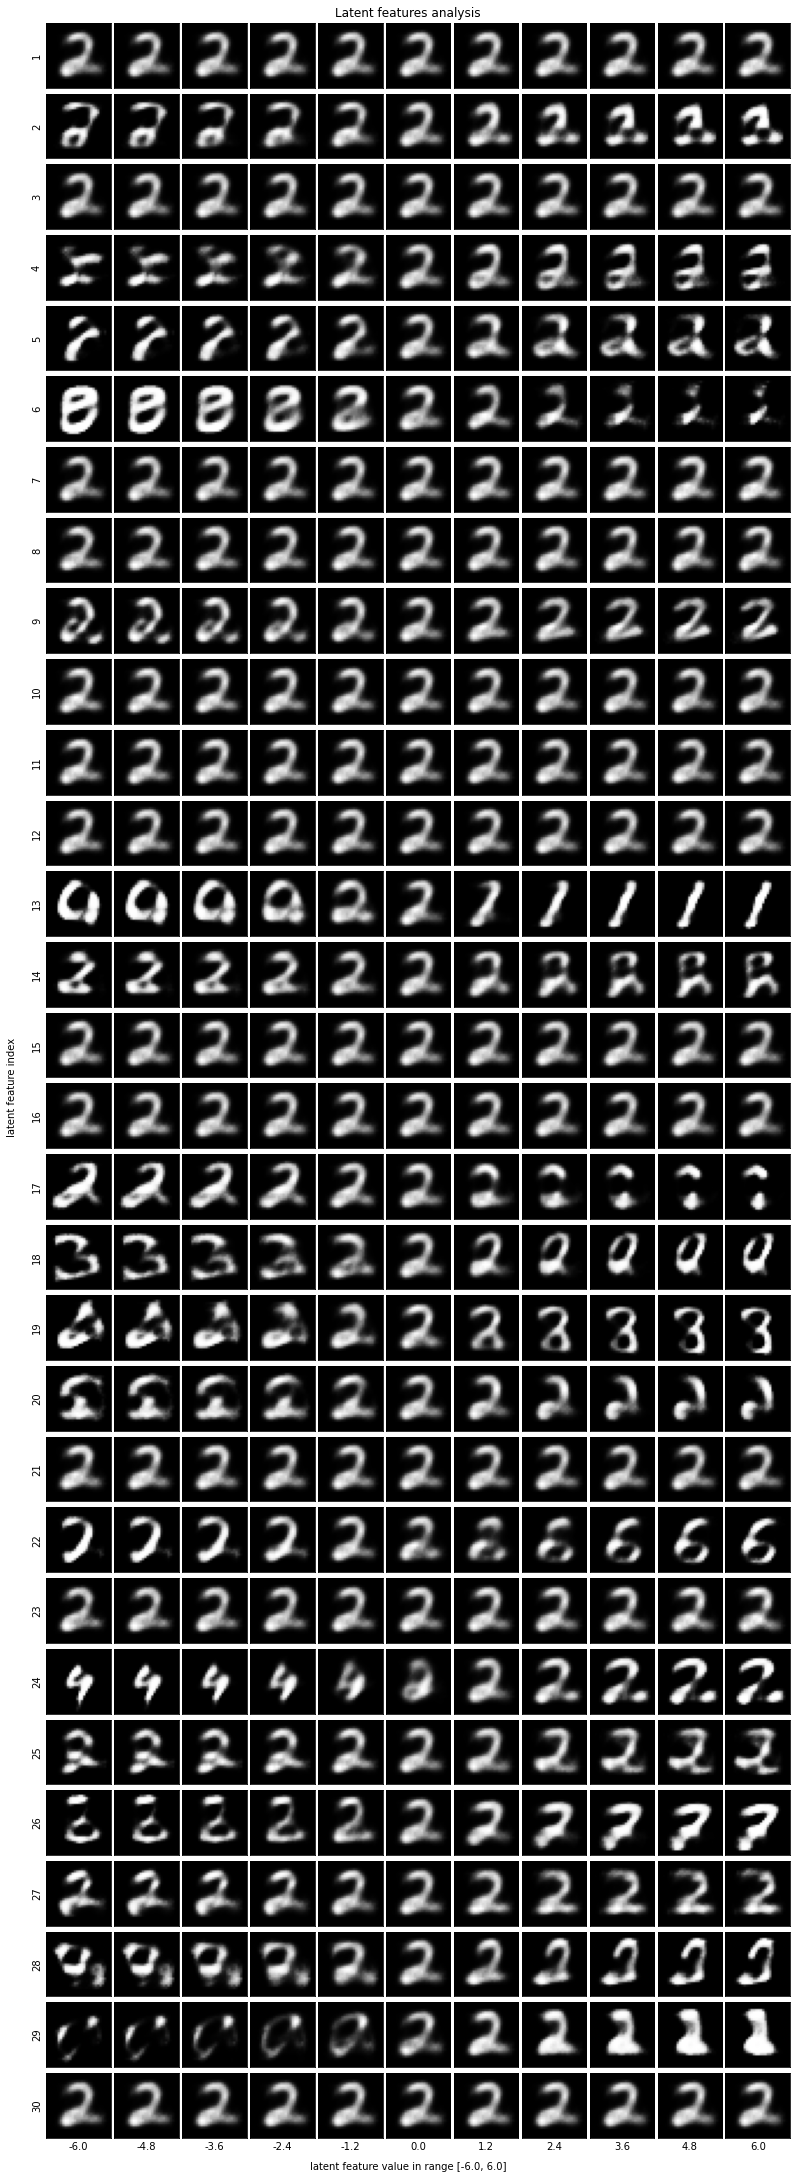

Digit: 3
Researching values in range [-6.0, 6.0]


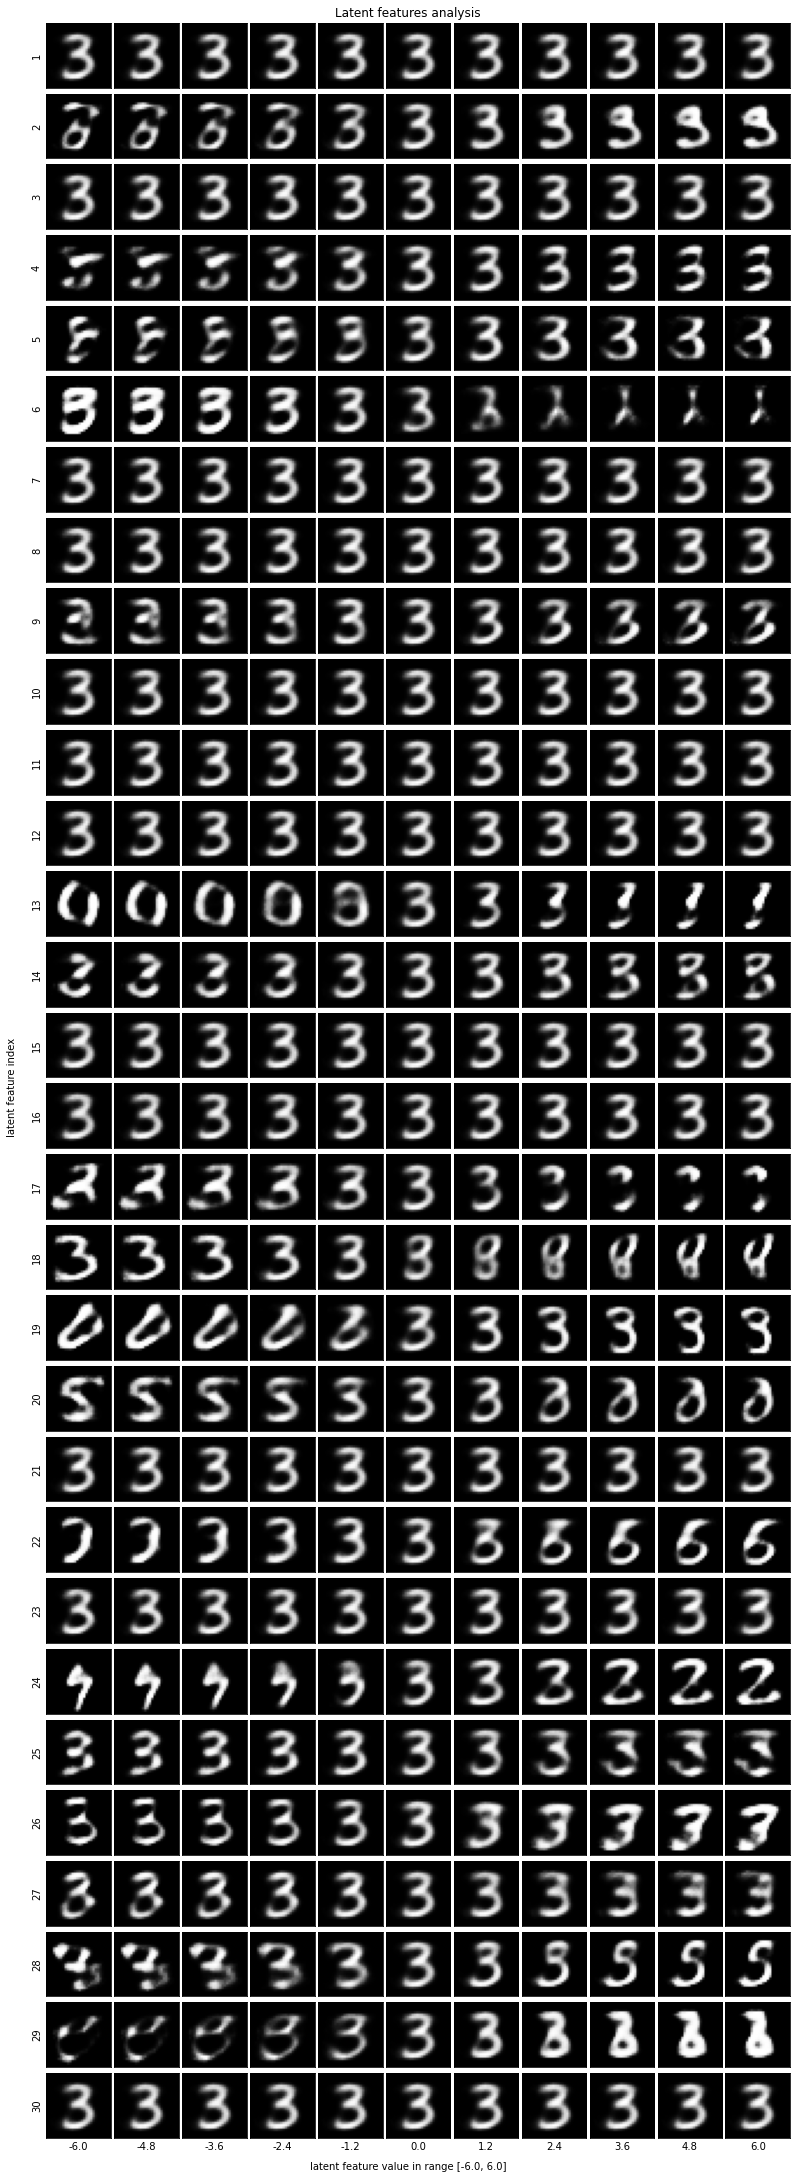

Digit: 4
Researching values in range [-6.0, 6.0]


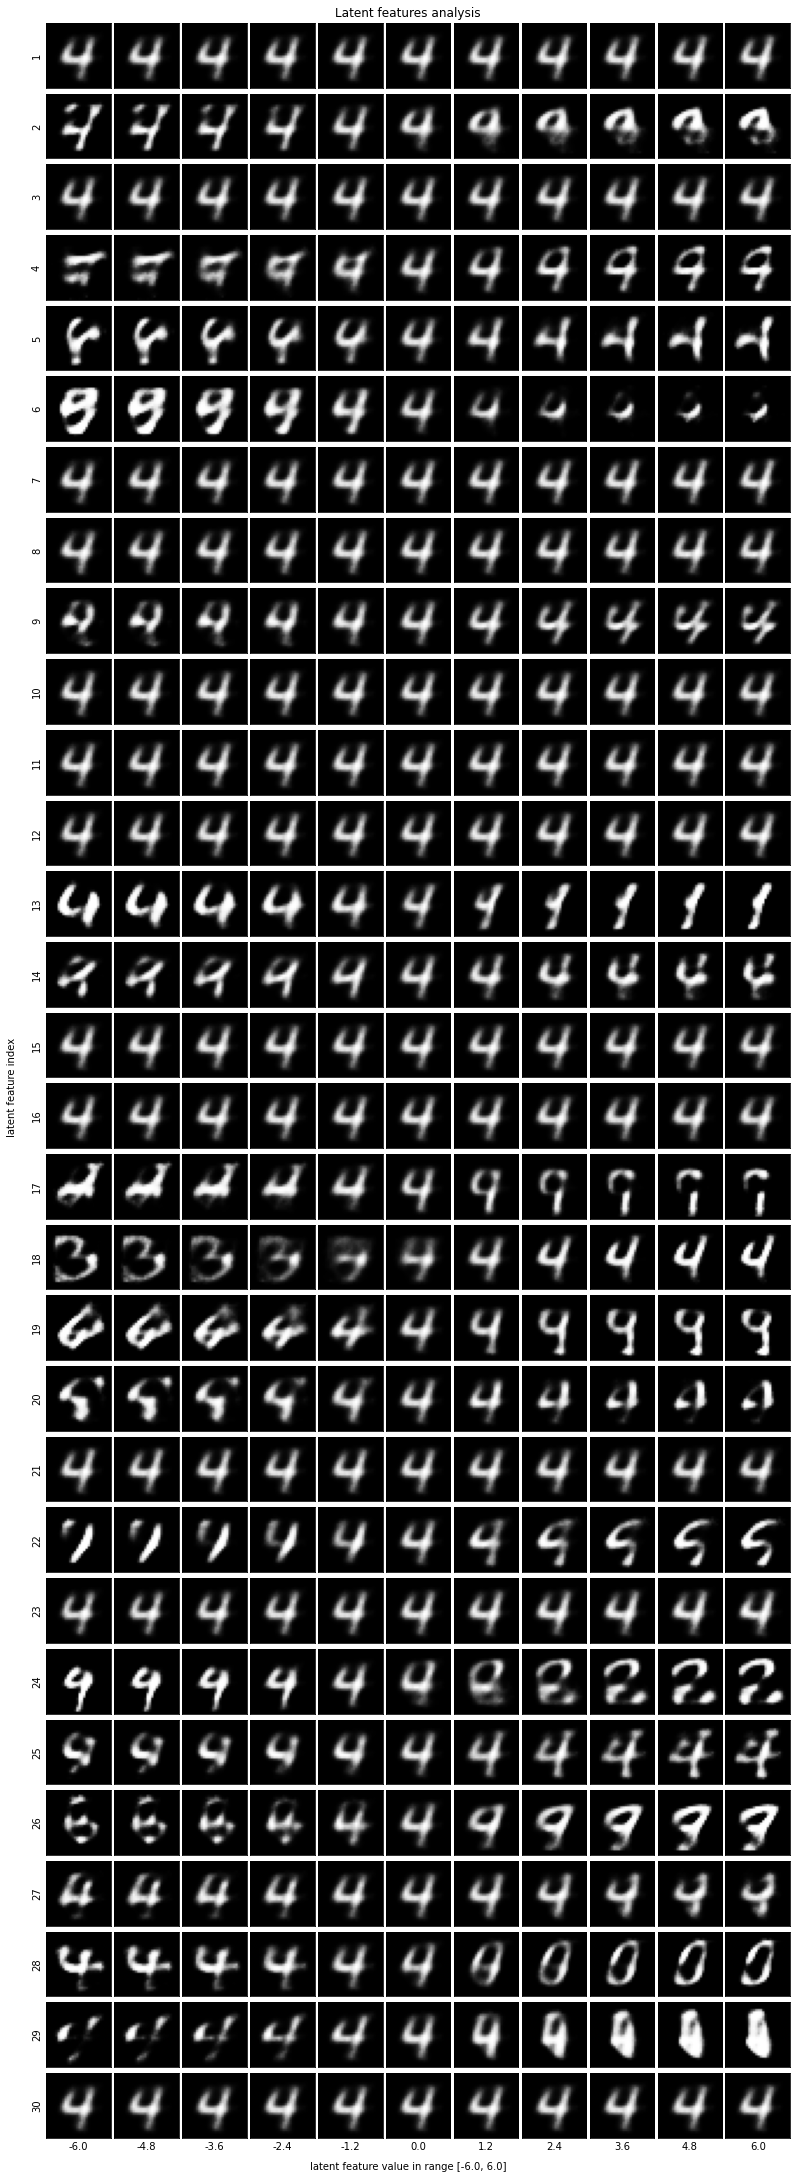

Digit: 5
Researching values in range [-6.0, 6.0]


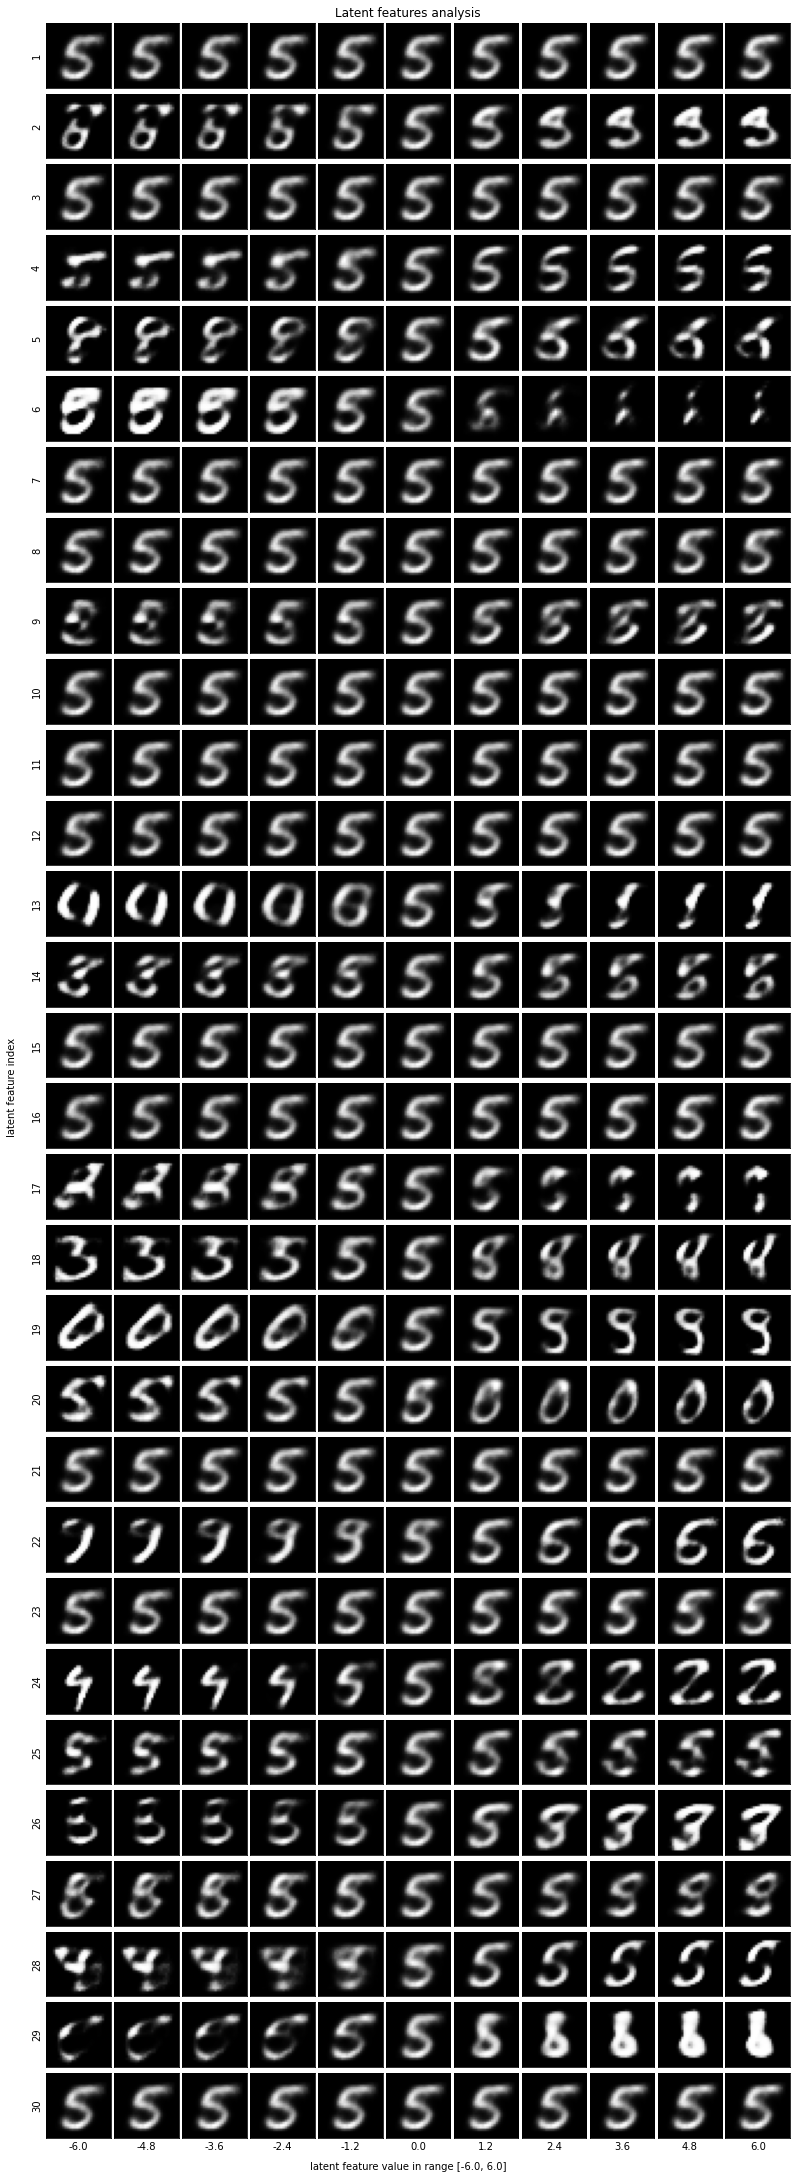

Digit: 6
Researching values in range [-6.0, 6.0]


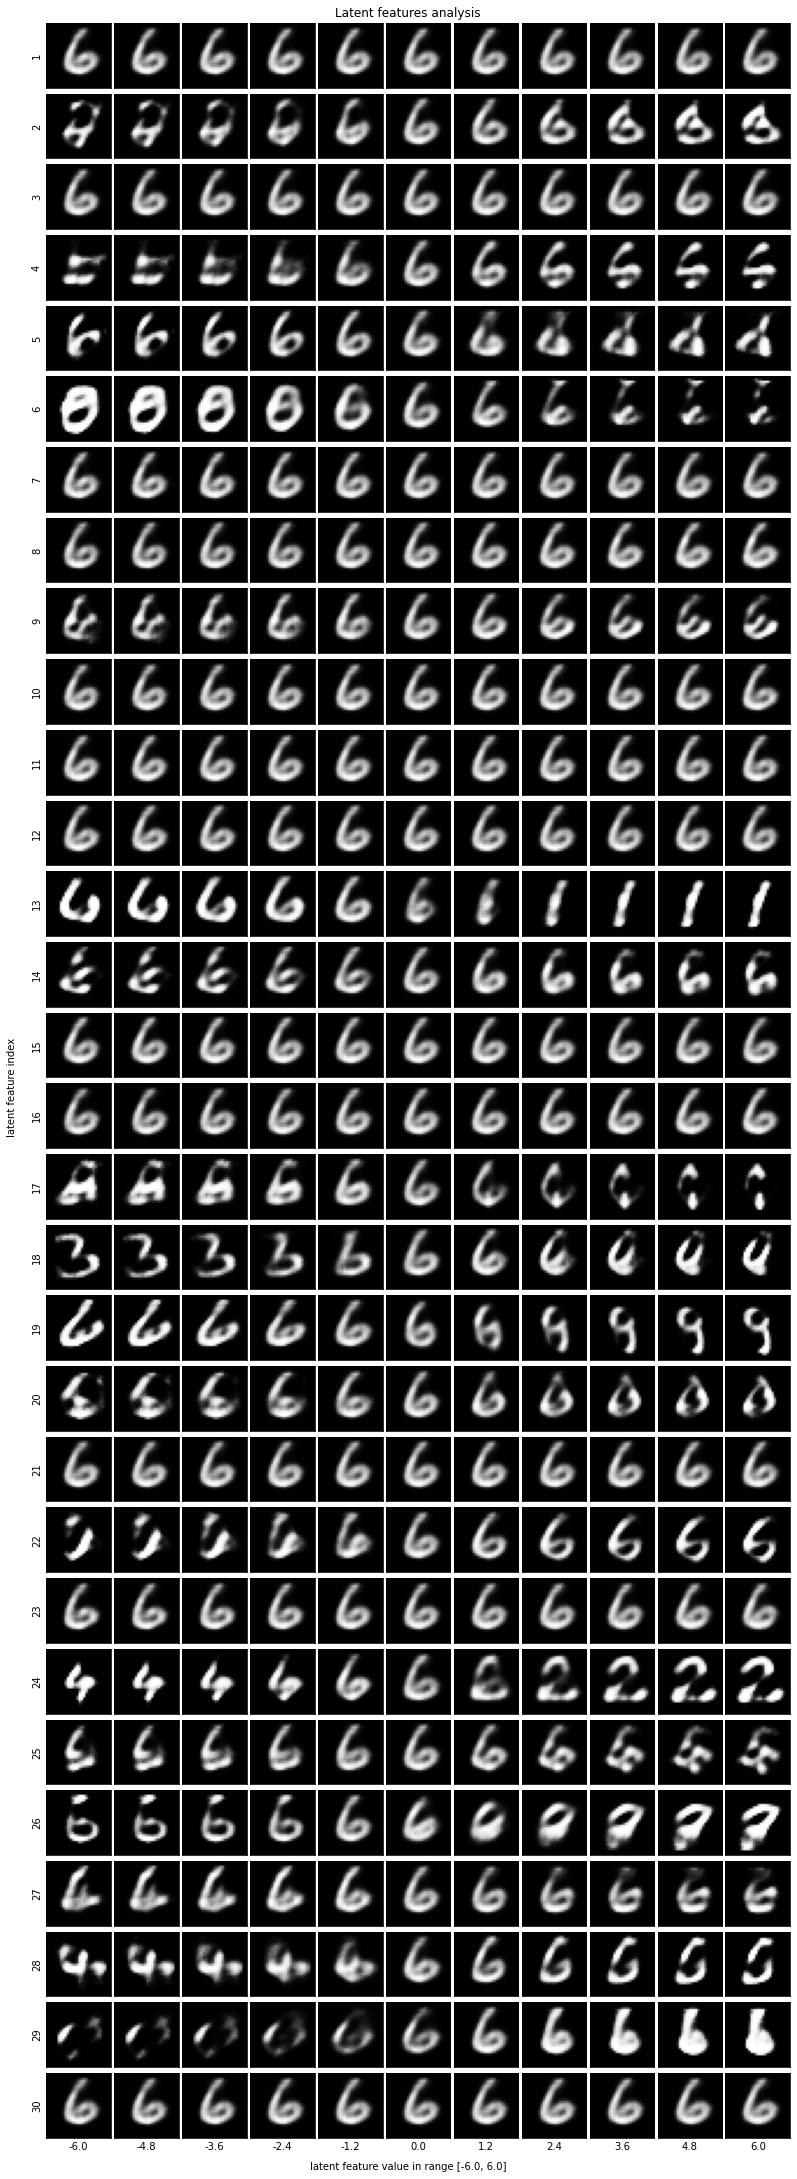

Digit: 7
Researching values in range [-6.0, 6.0]


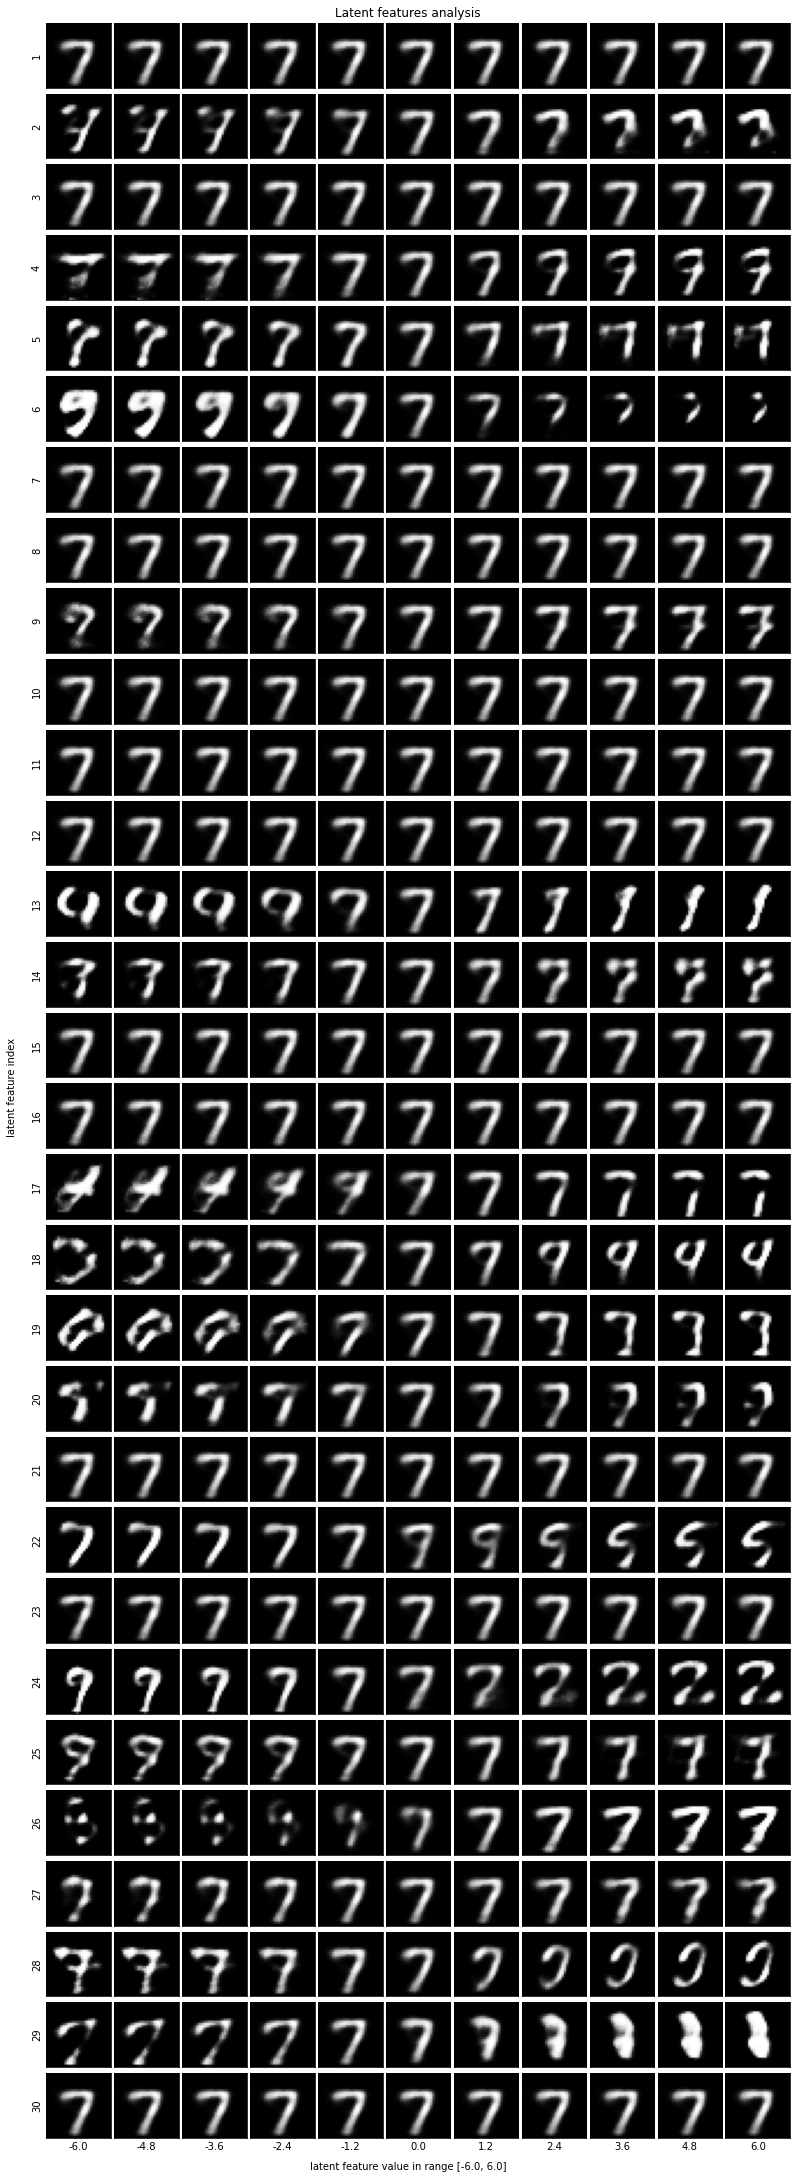

Digit: 8
Researching values in range [-6.0, 6.0]


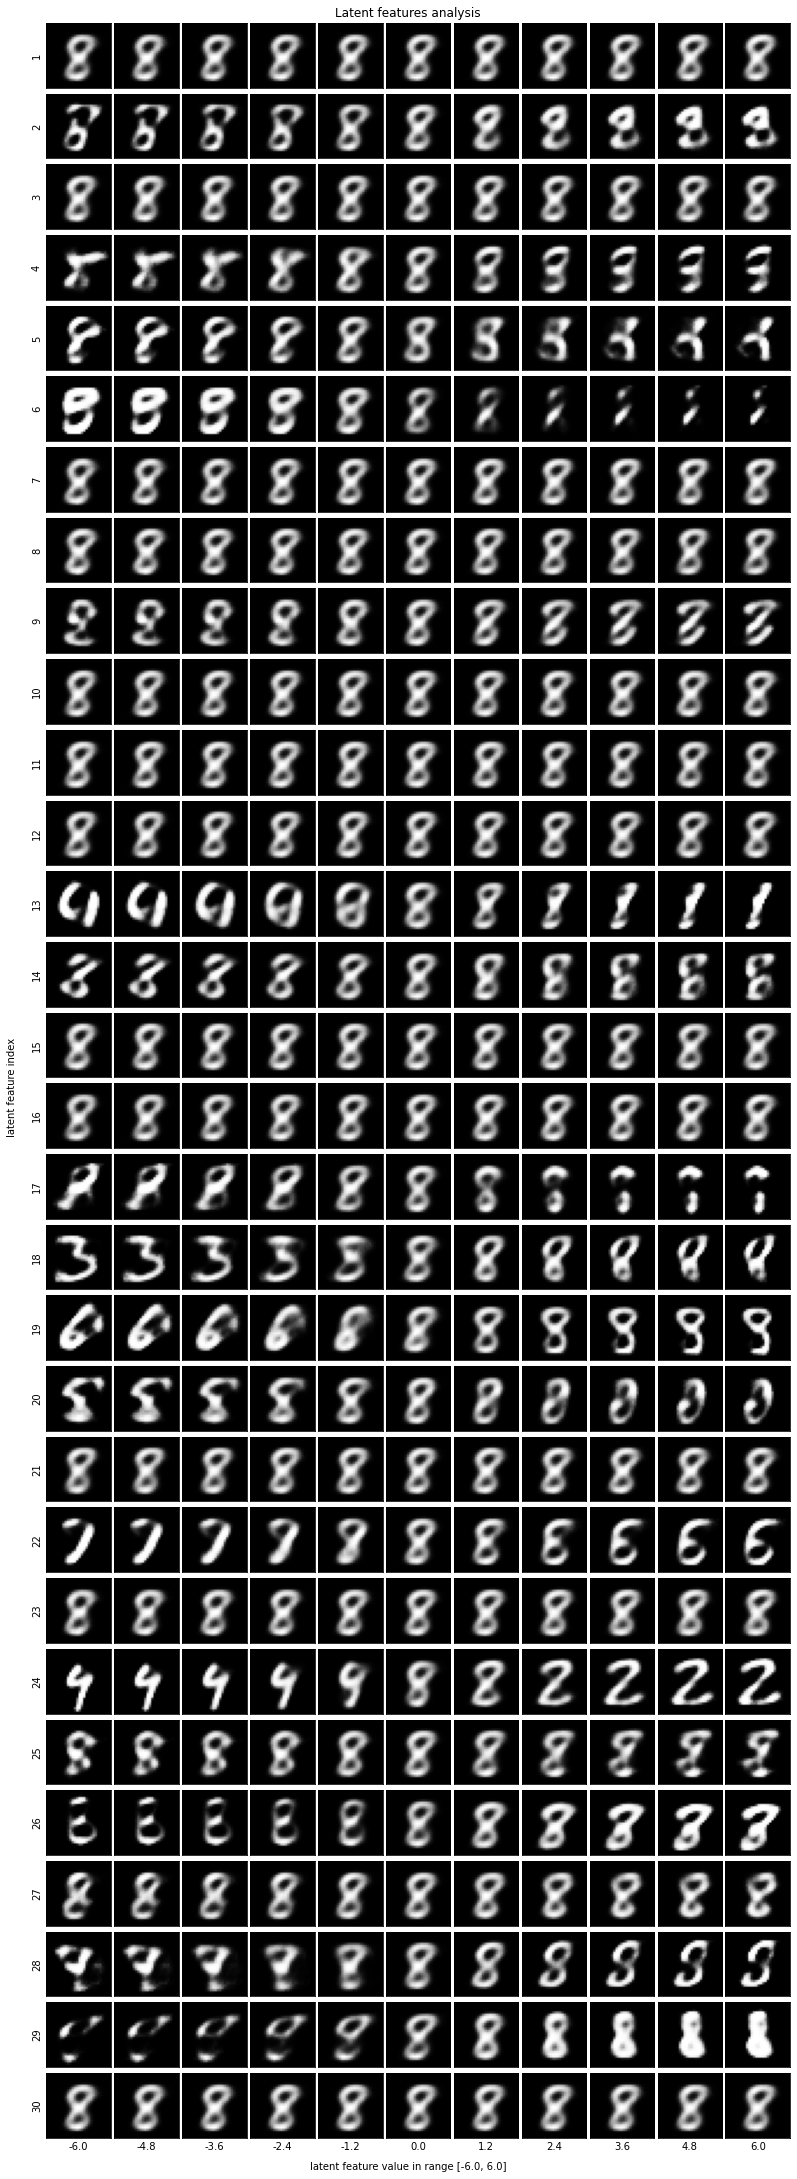

Digit: 9
Researching values in range [-6.0, 6.0]


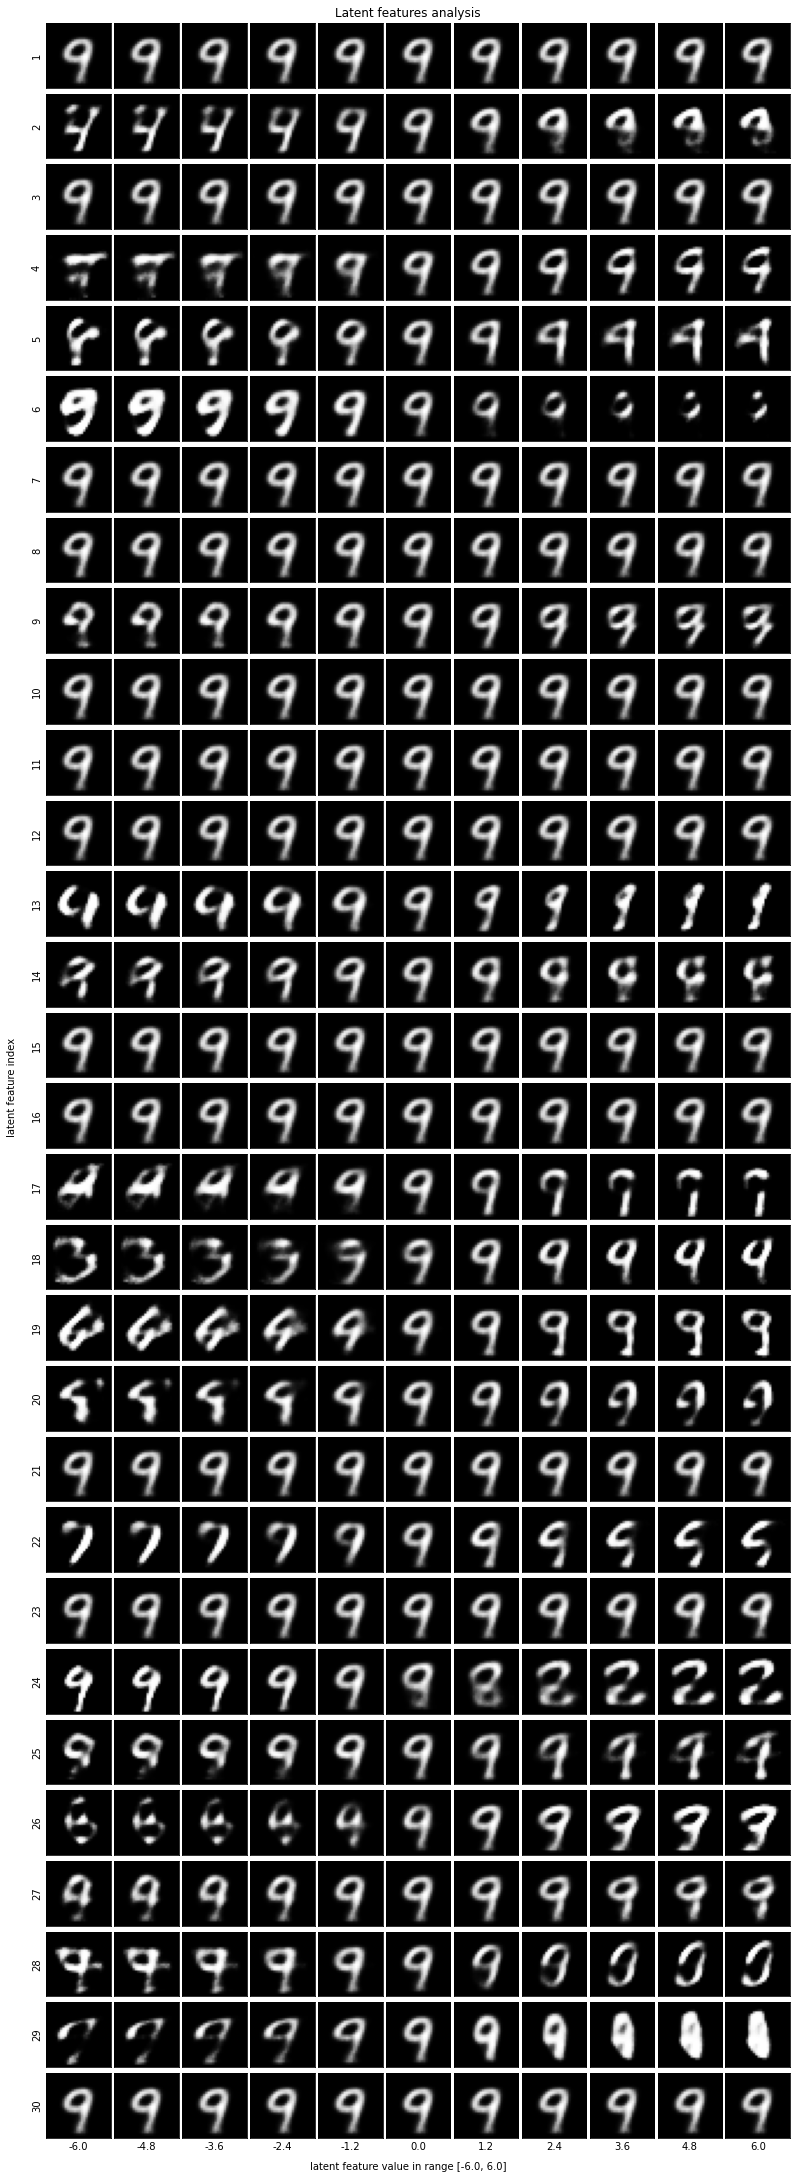

In [13]:
for digit, latent_code in enumerate(analyzer._averages):
    print(f"Digit: {digit}")
    analyzer.analyze_features(latent_code)
    plt.show()


### Latent space representation


In [ ]:
analyzer.analyze_tsne()  # this may take quite a long time
plt.show()
